# OVITO I/O
The lines in the first cell use OVITO modifiers to perform Wigner-Seitz analysis, which defines site occupancies via comparison with a perfect FCC lattice, allowing for the tracking of vacancy defects in the input file. This cell creates new files that show where the vacancies are by themselves and also shown with all the other atoms in the input file. Once the necessary files are created in your workspace/local storage you don't need to re-run this cell.


In [85]:
import os
from ovito.pipeline import *
from ovito.modifiers import *
from ovito.io import *

# custom modifier to select vacancies after Wigner-Seitz analysis
def modify(frame,data):
    occupancies = data.particles['Occupancy']
    total_occupancy = np.sum(occupancies, axis = 1)
    selection = data.particles_.create_property('Selection')
    selection[...] = (total_occupancy == 0)

filenames = ['15_50.lmp', '15_40.lmp', '15_30.lmp', '15_20.lmp', '15_10.lmp']
os.chdir('D:/Burke/Documents/Pitt/RESEARCH/NVT Simulations/Vacancy')

for file in filenames:
    pipeline = import_file(file)
    wigmod = WignerSeitzAnalysisModifier(per_type_occupancies = True, affine_mapping = ReferenceConfigurationModifier.AffineMapping.ToReference)
    wigmod.reference = FileSource()
    wigmod.reference.load('FCCreference.lmp')
    pipeline.modifiers.append(wigmod)
    pipeline.modifiers.append(ComputePropertyModifier(output_property='Particle Type', expressions = '3'))
    # see custom modifier above
    pipeline.modifiers.append(modify)
    pipeline.modifiers.append(InvertSelectionModifier())
    pipeline.modifiers.append(DeleteSelectedModifier())
    # export a file with the vacancies only (type = 3)
    export_file(pipeline, file.split('.')[0] + "vacancies.lmp", "lammps/dump", columns = ['Particle Identifier', 'Particle Type', 'Position.X', 'Position.Y', 'Position.Z'], multiple_frames = True)
    # new pipeline to combine the vacancies with the original data (this will append the vacancies at the end of the Particle IDs and reassign new IDs accordingly)
    newpipeline = import_file(file)
    mod = CombineDatasetsModifier()
    mod.source.load(file.split('.')[0] + 'vacancies.lmp')
    newpipeline.modifiers.append(mod)
    # make a new file with the vacancies and all atoms included for visualization
    export_file(newpipeline, "new" + file.split('.')[0] + ".lmp", "lammps/dump", columns = ['Particle Identifier', 'Particle Type', 'Position.X', 'Position.Y', 'Position.Z'], multiple_frames = True )

# LAMMPS Trajectory Tracking and Cross-Correlation Analysis
The following class parses data from the "new" files created above, allowing for trajectory analysis of both atoms and vacancies in the lattice. Statistical results are callable for the raw data as well as differenced time series data (trends/seasonality removed)

In [1]:
import os
from ovito.pipeline import *
from ovito.modifiers import *
from ovito.io import *
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pymatgen.optimization.neighbors import find_points_in_spheres


# general function for pandas dataframe cross-correlation with lag
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

class trajstats():
    """
    Takes LAMMPS NVT outputs, extracts per atom trajectories, and provides several functions to compare them
    Input parameters: filename and atomid (particle type label)
    """

    def __init__(self, filename, atomid, vacid, r = 3.0, fluctuating = False):
        self.filename = filename
        self.atomid = atomid
        self.vacid = vacid
        self.fluctuating = fluctuating
        self.pipeline = import_file(self.filename)
        data = self.pipeline.compute(0)
        data = pipeline.compute(0)
        # parameters for pymatgen's find_points_in_spheres
        self.r = r
        self.cell = np.array(data.cell).copy(order = 'C').astype('double')
        self.a = np.array([1, 1, 1]).copy(order='C')
        # parse this file into a numpy array and pandas dataframe for further study
        # put types and xyz positions into a dictionary
        self.trajs = {}
        self.vactrajs  = {}

        for frame_index in range(0, self.pipeline.source.num_frames):
            data = self.pipeline.compute(frame_index)
            pos = np.array(data.particles['Position'])
            types = np.array(data.particles['Particle Type'])
            # must be 2D for np.append
            types = np.reshape(types, (len(types), 1)) 
            self.trajs[frame_index] = np.append(types, pos, axis = 1)
            self.vactrajs[frame_index] = self.trajs[frame_index][np.ma.where(self.trajs[frame_index][:,0] == self.vacid)]


        for frame in range(len(self.vactrajs)-1):
            second = self.vactrajs[frame+1][:,1:].copy(order='C')
            first = self.vactrajs[frame][:,1:].copy(order='C')
            result = find_points_in_spheres(center_coords = first, all_coords = second, r = self.r, pbc = self.a, lattice = self.cell)
            self.vactrajs[frame+1] = second[result[1][:len(second)]]

        # atoms of interest, masking requires a reshape afterwards
        self.atomsvstime = self.trajs[frame_index][np.ma.where(self.trajs[frame_index][:,:,0] == self.atomid)]
        self.natoms = int( len(self.atomsvstime) / self.pipeline.source.num_frames)
        self.atomsvstime = np.reshape(self.atomsvstime, (self.pipeline.source.num_frames, self.natoms, 4))
        # vacancies only, same masking/reshaping as before
        self.vacsvstime = self.posvstime[np.ma.where(self.posvstime[:,:,0] == self.vacid)]
        self.nvacs = int( len(self.vacsvstime) / self.pipeline.source.num_frames)
        self.vacsvstime = np.reshape(self.vacsvstime, (self.pipeline.source.num_frames, self.nvacs, 4))
        # put only the z-coordinate atomic data into a pandas dataframe
        ids = [atom + 1 for atom in range(0, self.natoms)]
        self.df = pd.DataFrame(index = range(0, self.pipeline.source.num_frames))
        for atom_id in ids:
            # z -coordinate only over time for each atom of interest
            self.df[atom_id] = self.atomsvstime[:, atom_id - 1, 3]
        self.cols = list(self.df)
        # calculate variance of each particle's z-trajectory
        self.variances = {}
        for col in self.cols:
            self.variances[col] = self.df.var()[col]
        # differenced dataframe (removes trends from time series data)
        self.diffdf = self.df.diff(axis = 0, periods = 1)
        # drop first row where diff results in NaN
        self.diffdf.drop(labels = 0)
        self.diffvariances = {}
        for col in self.cols:
            self.diffvariances[col] = self.diffdf.var()[col]
    
        # same process for the vacancies in a dataframe
        ids = [vac + 1 for vac in range(0, self.nvacs)]
        self.vacdf = pd.DataFrame(index = range(0, self.pipeline.source.num_frames))
        for vac_id in ids:
            self.vacdf[vac_id] = self.vacsvstime[:, vac_id - 1, 3]
        self.vaccols = list(self.vacdf)
        self.vacvariances = {}
        for col in self.vaccols:
            self.vacvariances[col] = self.vacdf.var()[col]
        # differenced dataframe (removes trends from time series data)
        self.vacdiffdf = self.vacdf.diff(axis = 0, periods = 1)
        # drop first row where diff results in NaN
        self.vacdiffdf.drop(labels = 0)
        self.vacdiffvariances = {}
        for col in self.vaccols:
            self.vacdiffvariances[col] = self.vacdiffdf.var()[col]

    # some methods to return the data calculated above
    def posvstime(self):
        return self.posvstime

    def atomsvstime(self):
        return self.atomsvstime
    
    def vacsvstime(self):
        return self.vacsvstime

    def trajs(self):
        return self.trajs

    def shortest(self):
        return self.res

    def timestep(self):
        return self.timestep

    def df(self):
        return self.df
    
    def diffdf(self):
        return self.diffdf
    
    def cols(self):
        return  self.cols
    
    def variances(self):
        return self.variances

    def diffvariances(self):
        return self.diffvariances

    def vacdf(self):
        return self.vacdf

    def vacdiffdf(self):
        return self.vacdiffdf

    def vacvariances(self):
        return self.vacvariances

    def vacdiffvariances(self):
        return self.vacdiffvariances

    def vaccols(self):
        return self.vaccols

    # keep variances above 0.1 threshold
    def keeps(self, threshold):
        self.keeps = {}
        for key in self.variances.keys():
            # only relatively high variances are important
            if self.variances[key] > threshold:
                self.keeps[key] = self.df[key]
        return self.keeps

    def vackeeps(self,threshold):
        self.vackeeps = {}
        for key in self.vacvariances.keys():
            if self.vacvariances[key] > threshold:
                self.vackeeps[key] = self.vacdf[key]
        return self.vackeeps

    def diffkeeps(self, threshold):
        self.diffkeeps = {}
        for key in self.diffvariances.keys():
            if self.diffvariances[key] > threshold:
                self.diffkeepsp[key] = self.diffdf[key]
        return self.diffkeeps
    
    # plot a sampling of the trajectories over time
    def sample_ztraj(self, n):
        samples = self.df.sample(n, axis = 1)
        legend = []
        for col in list(samples):
            plt.plot(list(range(self.pipeline.source.num_frames)), self.df[col])
            legend.append(col)
        
        plt.legend(legend, loc = 'upper right')
        plt.show()
        return None

    def sample_vacs_ztraj(self,n):
        samples = self.vacdf.sample(n, axis = 1)
        legend = []
        for col in list(samples):
            plt.plot(list(range(self.pipeline.source.num_frames)), self.df[col])
            legend.append(col)
        plt.legend(legend, loc = 'upper right')
        plt.show()
        return None


    # Ackland-Jones analysis from OVITO vs time
    def acklandplot(self):
        for i in range(5):
            plt.plot(np.arange(1, self.pipeline.source.num_frames + 1), self.countsvstime[:,i])
        plt.legend(['Surface', 'FCC', 'HCP', 'BCC', 'ICO'])
        plt.show()
        return None

    def plot_variances(self):
        # initial z position on x axis and variance on y axis
        plt.plot([self.df[col][0] for col in self.cols], list(self.variances.values()), 'o')
        plt.show()
        return None

    def thresh_variance(self):
        leg_list = []
        # plot the trajectories that remain after filtering
        for key in self.keeps.keys():
            plt.plot(np.arange(1, self.pipeline.source.num_frames + 1), self.keeps[key])
            leg_list.append(key)
        plt.legend(leg_list, loc = 'upper right')
        plt.title('Nickel Trajectories w/ High Variance')
        plt.xlabel('Timestep')
        plt.ylabel('Z-Coordinate')

    def thresh_vacvariance(self):
        leg_list = []
        for key in self.vackeeps.keys():
            plt.plot(np.arange(1, self.pipeline.source.num_frames + 1), self.vackeeps[key])
            leg_list.append(key)
        plt.legend(leg_list, loc ='upper right')
        plt.title('Vacancy Trajectories w/ High Variance')
        plt.xlabel('Timestep')
        plt.ylabel('Z-Coordinate')

        
    # raw cross correlation
    def cross(self, atomid1, atomid2, differenced = False):
        if differenced:
            d1 = self.diffdf[atomid1]
            d2 = self.diffdf[atomid2]
        else: 
            d1 = self.df[atomid1]
            d2 = self.df[atomid2]
        seconds = 5
        fps = 10
        rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
        offset = np.ceil(len(rs)/2)-np.argmax(rs)
        f,ax=plt.subplots(figsize=(14,3))
        ax.plot(rs)
        ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
        ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
        ax.set(title=f'Offset = {offset} frames\n Atom 1 leads <> Atom 2 leads', xlabel='Offset',ylabel='Pearson r')
        ax.set_xticks([0, 25, 50, 75, 100])
        ax.set_xticklabels([-50, -25, 0, 25, 50])
        plt.legend()
        plt.show()
        return None

    # Windowed, time-lagged cross correlation
    def windowedcross(self, atomid1, atomid2, differenced = False):
        no_splits = 20
        samples_per_split = thousand.df.shape[0]/no_splits
        rss=[]
        seconds = 5
        fps = 10
        if differenced:
            for t in range(0, no_splits):
                d1 = self.diffdf[atomid1].loc[(t)*samples_per_split:(t+1)*samples_per_split]
                d2 = self.diffdf[atomid2].loc[(t)*samples_per_split:(t+1)*samples_per_split]
                rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
                rss.append(rs)
        else:
            for t in range(0, no_splits):
                d1 = self.df[atomid1].loc[(t)*samples_per_split:(t+1)*samples_per_split]
                d2 = self.df[atomid2].loc[(t)*samples_per_split:(t+1)*samples_per_split]
                rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
                rss.append(rs)      
        rss = pd.DataFrame(rss)
        f,ax = plt.subplots()
        sns.heatmap(rss,cmap='coolwarm',ax=ax)
        ax.set(title=f'Windowed Time-Lagged Cross Correlation',xlabel='Offset',ylabel='Window epochs')
        #ax.set_xlim(85, 215)
        ax.set_xticks([0, 25, 50, 75, 100])
        ax.set_xticklabels([-50, -25, 0, 25, 50])
        plt.show()
        return None
       
    # Rolling window, time-lagged cross correlation
    def rollingcross(self, atomid1, atomid2, differenced = False):
        seconds = 5
        fps = 10
        window_size = 300 #samples, should be a pretty high number compared to fps*sec to get good rolling averages
        t_start = 0
        t_end = t_start + window_size
        step_size = 20
        rss=[]
        while t_end < self.pipeline.source.num_frames:
            if differenced:
                d1 = self.diffdf[atomid1].iloc[t_start:t_end]
                d2 = self.diffdf[atomid2].iloc[t_start:t_end]
            else:
                d1 = self.df[atomid1].iloc[t_start:t_end]
                d2 = self.df[atomid2].iloc[t_start:t_end]
            rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
            rss.append(rs)
            t_start = t_start + step_size
            t_end = t_end + step_size
        rss = pd.DataFrame(rss)

        f,ax = plt.subplots()
        sns.heatmap(rss,cmap='coolwarm',ax=ax)
        ax.set(title=f'Rolling-Window Time-Lagged Cross Correlation', xlabel='Offset',ylabel='Epochs')
        ax.set_xticks([0, 25, 50, 75, 100])
        ax.set_xticklabels([-50, -25, 0, 25, 50])
        plt.show()
        return None

        # Rolling window, time-lagged cross correlation for dataframes in different classes
    def rollingcrossvacs(atomid1, atomid2, differenced = False):
        seconds = 5
        fps = 10
        window_size = 300 #samples, should be a pretty high number compared to fps*sec to get good rolling averages
        t_start = 0
        t_end = t_start + window_size
        step_size = 20
        rss=[]
        while t_end < self.pipeline.source.num_frames:
            if differenced:
                d1 = self.diffdf[atomid1].iloc[t_start:t_end]
                d2 = self.vacdiffdf[atomid2].iloc[t_start:t_end]
            else:
                d1 = self.df[atomid1].iloc[t_start:t_end]
                d2 = self.vacdf[atomid2].iloc[t_start:t_end]
            rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
            rss.append(rs)
            t_start = t_start + step_size
            t_end = t_end + step_size
        rss = pd.DataFrame(rss)

        f,ax = plt.subplots()
        sns.heatmap(rss,cmap='coolwarm',ax=ax)
        ax.set(title=f'Rolling-Window Time-Lagged Cross Correlation', xlabel='Offset',ylabel='Epochs')
        ax.set_xticks([0, 25, 50, 75, 100])
        ax.set_xticklabels([-50, -25, 0, 25, 50])
        plt.show()
        return None

In [2]:
os.chdir('D:/Burke/Documents/Pitt/RESEARCH/NVT Simulations/Temperature')
pipeline = import_file('new900.lmp')
data = pipeline.compute(0)
cell = np.array(data.cell).copy(order = 'C').astype('double')
a = np.array([1, 1, 1]).copy(order='C')
# parse this file into a numpy array and pandas dataframe for further study
# put types and xyz positions into a dictionary
trajs = {}
vactrajs = {}

for frame_index in range(0, pipeline.source.num_frames):
    data = pipeline.compute(frame_index)
    pos = np.array(data.particles['Position'])
    types = np.array(data.particles['Particle Type'])
    # must be 2D for np.append
    types = np.reshape(types, (len(types), 1)) 
    trajs[frame_index] = np.append(types, pos, axis = 1)
    vactrajs[frame_index] = trajs[frame_index][np.ma.where(trajs[frame_index][:,0] == 3)]
len(vactrajs)

1300

In [ ]:
second = vactrajs[1][:,1:].copy(order='C')
first = vactrajs[0][:,1:].copy(order='C')
result = find_points_in_spheres(center_coords = first, all_coords = second, r = 3, pbc = a, lattice = cell)
tracktrajs[1] = second[result[1][:len(second)]]

In [6]:
tracktrajs = {}
tracktrajs[0] = vactrajs[0]
for frame in range(len(vactrajs)-1):
    second = vactrajs[frame+1][:,1:].copy(order='C')
    first = vactrajs[frame][:,1:].copy(order='C')
    result = find_points_in_spheres(center_coords = first, all_coords = second, r = 3, pbc = a, lattice = cell)
    tracktrajs[frame+1] = second[result[1][:len(second)]]

AttributeError: module 'pymatgen.optimization' has no attribute 'neighbors'

In [2]:
os.chdir("D:/Burke/Documents/Pitt/RESEARCH/NVT Simulations/Temperature")
atomid = 2
vacid = 3
thousand = trajstats('new1000.lmp', atomid, vacid, fluctuating = True)
nine = trajstats('new900.lmp', atomid, vacid, fluctuating = False)
eight = trajstats('new800.lmp', atomid, vacid, fluctuating = False)
seven = trajstats('new700.lmp', atomid, vacid, fluctuating = False)
six = trajstats('new600.lmp', atomid, vacid, fluctuating = False)
#sanity check
thou_df = thousand.df
thou_df.head()

,1,2,3,4,5,6,7,8,9,10,...,59,60,61,62,63,64,65,66,67,68
0,8.242974,8.295386,8.702979,6.754717,7.334889,7.494397,7.566579,7.675467,6.089508,6.888431,...,13.197678,12.927952,15.614685,15.407564,15.393925,14.397186,15.434514,13.423778,14.575991,12.559461
1,7.766876,7.925189,8.307290,6.352258,7.533065,7.625457,6.899279,7.804426,5.734854,6.762700,...,13.166983,13.254058,15.327423,15.525637,15.420545,14.918773,15.299638,13.375345,14.684954,12.525982
2,7.912987,7.802311,8.526886,6.290021,7.924665,7.677387,7.422698,7.809654,6.038294,6.532124,...,13.087779,13.056881,15.458174,15.262136,15.311886,14.407156,15.666738,13.494177,15.031203,13.057109
3,7.993700,7.790610,8.482286,6.404958,7.576046,7.584612,7.342415,7.495245,6.038128,7.299609,...,13.029172,12.976513,15.523992,15.436386,15.039604,14.906398,15.651276,13.763093,15.341518,12.636641
4,7.897845,7.973762,8.370884,7.040091,7.360232,7.478895,7.591381,7.751589,5.955564,6.780849,...,13.301328,12.897561,15.406046,15.233086,15.151958,14.527102,15.621973,13.791182,14.894379,12.657518


# Some Quick Visualizations to find Patterns/Trends

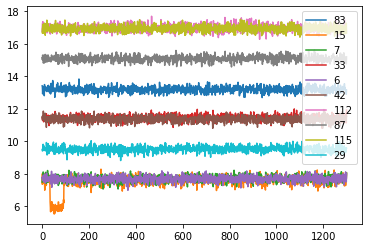

In [57]:
nine.sample_ztraj(10)

## Variance Analysis with Temperature as Free Variable
Identifying the Nickel atoms with appreciable variance will expose the migration events quickly. Obviously we expect Nickel migration towards the center of the slab, so variance will be higher at the two surfaces.

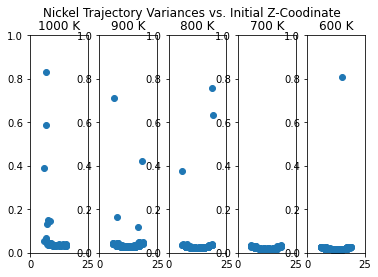

In [46]:
fig, ax = plt.subplots(1,5)
(ax1, ax2, ax3, ax4, ax5) = ax
fig.suptitle('Nickel Trajectory Variances vs. Initial Z-Coodinate')
plt.setp(ax, xlim = (0, 25), ylim = (0, 1))
ax1.plot([thousand.df[col][0] for col in thousand.cols], list(thousand.variances.values()), 'o')
ax1.title.set_text('1000 K')
ax2.plot([nine.df[col][0] for col in nine.cols], list(nine.variances.values()), 'o')
ax2.title.set_text('900 K')
ax3.plot([eight.df[col][0] for col in eight.cols], list(eight.variances.values()), 'o')
ax3.title.set_text('800 K')
ax4.plot([seven.df[col][0] for col in seven.cols], list(seven.variances.values()), 'o')
ax4.title.set_text('700 K')
ax5.plot([six.df[col][0] for col in six.cols], list(six.variances.values()), 'o')
ax5.title.set_text('600 K')
plt.show()

Across all temperatures, the higher variance is near the surface (notice the consistent convex shape) so now we threshold mask for variances higher than 0.1 to only track the few trajectories that matter for this study.
Clearly the temperature increases the amount of segregation, but, even at a low temperature like 600 K, the odd segregation event still occurs.

In [66]:
from operator import itemgetter
res = dict(sorted(nine.variances.items(), key = itemgetter(1), reverse = True)[:10])
print("The top ten variances for T = 900 are "  + str(res) + '\n')

The top ten variances for T = 900 are {4: 0.7138849610687368, 111: 0.42144494866619603, 15: 0.166420651987927, 104: 0.11915701617816477, 98: 0.05054362363699014, 105: 0.0476345084201688, 96: 0.04762918550455976, 89: 0.04635101186340281, 103: 0.04579031374492809, 102: 0.0455839516294176}



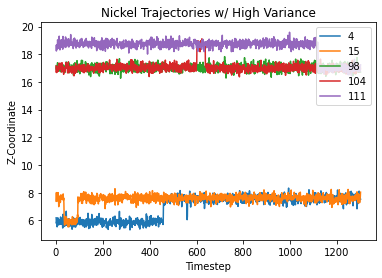

In [65]:
nine.keeps(0.05)
nine.thresh_variance()

## Nickel Concentration As Free Variable

In [3]:
os.chdir("D:/Burke/Documents/Pitt/RESEARCH/NVT Simulations/Concentration")
fifteen = trajstats('new15.lmp', atomid, vacid)
twelvefive = trajstats('new12_5.lmp', atomid, vacid)
ten = trajstats('new10.lmp', atomid, vacid)
sevenfive = trajstats('new7_5.lmp', 1, vacid)
five = trajstats('new5.lmp', atomid, vacid)

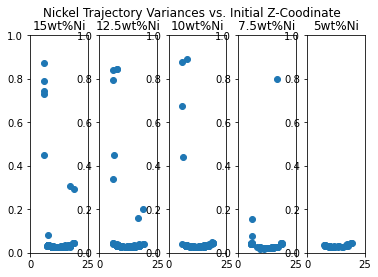

In [5]:
fig, ax = plt.subplots(1,5)
(ax1, ax2, ax3, ax4, ax5) = ax
fig.suptitle('Nickel Trajectory Variances vs. Initial Z-Coodinate')
plt.setp(ax, xlim = (0, 25), ylim = (0, 1))
ax1.plot([fifteen.df[col][0] for col in fifteen.cols], list(fifteen.variances.values()), 'o')
ax1.title.set_text('15wt%Ni')
ax2.plot([twelvefive.df[col][0] for col in twelvefive.cols], list(twelvefive.variances.values()), 'o')
ax2.title.set_text('12.5wt%Ni')
ax3.plot([ten.df[col][0] for col in ten.cols], list(ten.variances.values()), 'o')
ax3.title.set_text('10wt%Ni')
ax4.plot([sevenfive.df[col][0] for col in sevenfive.cols], list(sevenfive.variances.values()), 'o')
ax4.title.set_text('7.5wt%Ni')
ax5.plot([five.df[col][0] for col in five.cols], list(five.variances.values()), 'o')
ax5.title.set_text('5wt%Ni')
plt.show()

In [89]:
res = dict(sorted(fifteen.variances.items(), key = itemgetter(1), reverse = True)[:10])
print("The top ten variances for 15% are "  + str(res) + '\n')

The top ten variances for 15% are {436: 1.4137503013800667, 167: 0.9380888039737018, 127: 0.9346164182071426, 156: 0.9340246655910739, 31: 0.9330810981489129, 90: 0.9275851132947358, 46: 0.9271454563228558, 92: 0.924699029486514, 4: 0.9237538378968361, 16: 0.9221636590789937}



## Vacancy Concentration as Free Variable

In [4]:
os.chdir("D:/Burke/Documents/Pitt/RESEARCH/NVT Simulations/Vacancy")
atomid = 1
tens = trajstats('new15_10.lmp', atomid, vacid)
twenty = trajstats('new15_20.lmp', atomid, vacid)
thirty = trajstats('new15_30.lmp', atomid, vacid)
forty = trajstats('new15_40.lmp', atomid, vacid)
fifty = trajstats('new15_50.lmp', atomid, vacid)

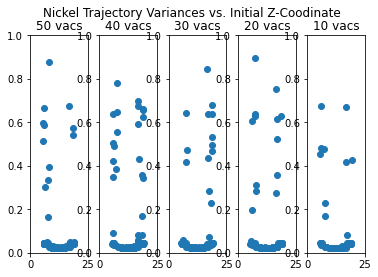

In [27]:
fig, ax = plt.subplots(1,5)
(ax1, ax2, ax3, ax4, ax5) = ax
fig.suptitle('Nickel Trajectory Variances vs. Initial Z-Coodinate')
plt.setp(ax, xlim = (0, 25), ylim = (0, 1))
ax1.plot([fifty.df[col][0] for col in fifty.cols], list(fifty.variances.values()), 'o')
ax1.title.set_text('50 vacs')
ax2.plot([forty.df[col][0] for col in forty.cols], list(forty.variances.values()), 'o')
ax2.title.set_text('40 vacs')
ax3.plot([thirty.df[col][0] for col in thirty.cols], list(thirty.variances.values()), 'o')
ax3.title.set_text('30 vacs')
ax4.plot([twenty.df[col][0] for col in twenty.cols], list(twenty.variances.values()), 'o')
ax4.title.set_text('20 vacs')
ax5.plot([tens.df[col][0] for col in tens.cols], list(tens.variances.values()), 'o')
ax5.title.set_text('10 vacs')
plt.show()

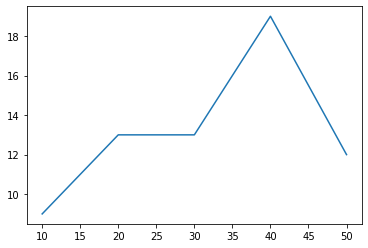

In [28]:
keepers = [ len(fifty.keeps()), len(forty.keeps()), len(thirty.keeps()), len(twenty.keeps()), len(tens.keeps()) ]
vacs = [50, 40, 30, 20, 10]
plt.plot(vacs, keepers)

## Time-Lagged Cross Correlation to Assess Dynamics
Leader-follower relationships can be determined based on the different lag times possible between two test signals that we wish to compare. For this analysis, we know to compare atoms in the same layers i.e. near two initial regions. The thresholding method included in the trajstats class allows us to quickly find atoms with high variance and narrow down the atoms that we will check for cross-correlation.

The function for cross-correlation and the rolling window technique were found at https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9

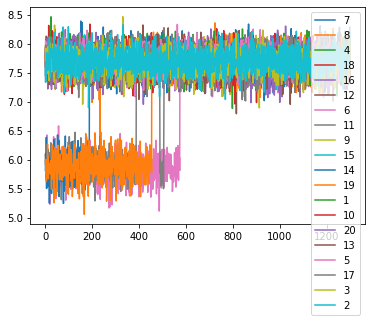

In [16]:
fifteen.sample_vacs_ztraj(20)

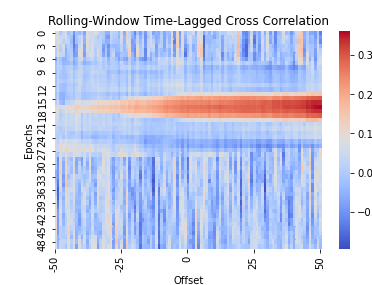

In [41]:
fifteen.rollingcross(6,26, differenced = False)

In [10]:
fifteen.rollingcrossv

AttributeError: 'trajstats' object has no attribute 'rollingcrossvacs'